In [2]:
import pyomo.environ as pyo
import re
import sys, os
current_dir = os.getcwd()
sys.path.append(current_dir)

Se ha colocado un límite de tiempo de 30 segundos para la ejecución del modelo.


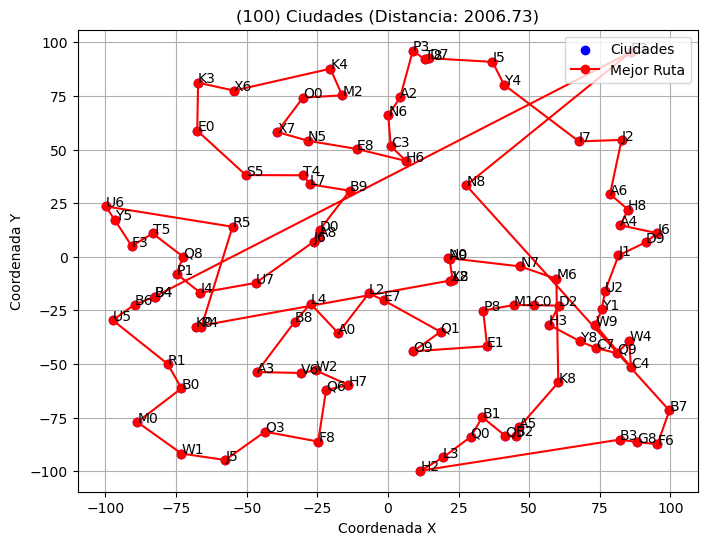

B4 0.6403124237432862 100.94053659793774 8.006247560499245 203.44102339498787 106.77422691409892
B4 0.6403124237432862 100.94053659793774 8.006247560499245 203.44102339498787 106.77422691409892
B4 0.6403124237432862 100.94053659793774 8.006247560499245 203.44102339498787 106.77422691409892
B4 0.6403124237432862 100.94053659793774 8.006247560499245 203.44102339498787 106.77422691409892
B4 0.6403124237432862 100.94053659793774 8.006247560499245 203.44102339498787 106.77422691409892
B4 0.6403124237432862 100.94053659793774 8.006247560499245 203.44102339498787 106.77422691409892
B4 0.6403124237432862 100.94053659793774 8.006247560499245 203.44102339498787 106.77422691409892
B4 0.6403124237432862 100.94053659793774 8.006247560499245 203.44102339498787 106.77422691409892
B4 0.6403124237432862 100.94053659793774 8.006247560499245 203.44102339498787 106.77422691409892
B4 0.6403124237432862 100.94053659793774 8.006247560499245 203.44102339498787 106.77422691409892
B4 0.6403124237432862 100.9405

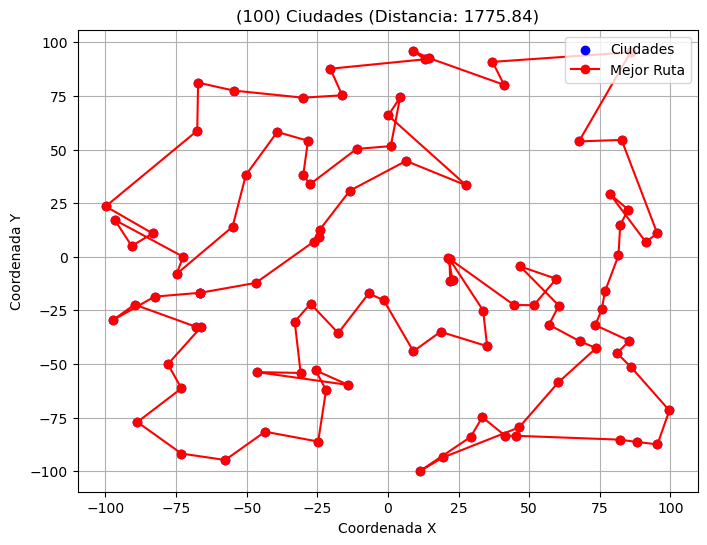

In [3]:
from util import *
from util_nearest_neighbor import nearest_neighbor
# https://baobabsoluciones.es/blog/2020/10/01/problema-del-viajante/

class TSP:
    def __init__(self, ciudades, distancias, heuristics: List[str]):
        self.max_possible_distance = None
        self.min_possible_distance = None
        self.ciudades = ciudades
        self.distancias = distancias
        self.heuristics = heuristics
        self.min_distance = get_min_distance(distancias)
        self.max_distance = get_max_distance(distancias)
        self.average_distance = get_average_distance(distancias)
        self.average_distance_for_city = get_average_distance_for_city(distancias)
        self.min_distance_for_city = get_min_distances(distancias)
        self.max_distance_for_city = get_max_distances(distancias)
        self.cal_min_max_distances()

    def cal_min_max_distances(self):
        medium_low_distance = (self.min_distance + self.average_distance) / 2
        self.min_possible_distance = medium_low_distance * len(self.ciudades) * 0.25
        self.max_possible_distance = medium_low_distance * len(self.ciudades) * 0.6


    def print_min_max_distances(self):
        print(f"Distancia mínima entre nodos: {self.min_distance}")
        print(f"Distancia máxima entre nodos: {self.max_distance}")
        print(f"Distancia promedio entre nodos: {self.average_distance}")
        print(f"Distancia Total mínima posible: {self.min_possible_distance}")
        print(f"Distancia Total máxima posible: {self.max_possible_distance}")
        print(f"Heurísticas aplicadas: {self.heuristics}")

    def encontrar_la_ruta_mas_corta(self, mipgap, time_limit, tee):
        start_time = dt.datetime.now()

        _model = pyo.ConcreteModel()

        cities = list(self.ciudades.keys())
        n_cities = len(cities)


        # Sets to work with (conjuntos)
        _model.M = pyo.Set(initialize=self.ciudades.keys())
        _model.N = pyo.Set(initialize=self.ciudades.keys())

        # Index for the dummy variable u
        _model.U = pyo.Set(initialize=cities[1:])

        # Variables
        _model.x = pyo.Var(_model.N, _model.M, within=pyo.Binary)
        _model.u = pyo.Var(_model.N, bounds=(0, n_cities - 1), within=pyo.NonNegativeIntegers)

        # Objetive Function: (función objetivo a minimizar)
        def obj_rule(model):
            return sum(self.distancias[i, j] * model.x[i, j] for i in model.N for j in model.M if i != j)

        _model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

        # Restricciones
        # Desde cada ciudad exactamente una arista
        def regla_una_entrada_una_salida_por_ciudad_desde(model, city_j):
            return sum(model.x[i, city_j]  for i in model.N if city_j != i) == 1

        _model.one_way_i_j = pyo.Constraint(_model.M, rule=regla_una_entrada_una_salida_por_ciudad_desde)

        # Hacia cada ciudad exactamente una arista
        def regla_una_entrada_una_salida_por_ciudad_hacia(model, city_i):
            return sum(model.x[city_i, j] for j in model.M if city_i != j) == 1

        _model.one_way_j_i = pyo.Constraint(_model.N, rule=regla_una_entrada_una_salida_por_ciudad_hacia)

        def rule_formando_path(model, i, j):
            if i != j:
                return model.u[i] - model.u[j] + model.x[i, j] * n_cities <= n_cities - 1
            else:
                # No se puede ir de una ciudad a la misma
                return pyo.Constraint.Skip

        _model.complete_path = pyo.Constraint(_model.U, _model.N, rule=rule_formando_path)

        def rule_asegurar_viaje(model, i, j):
            if i == j:
                return model.x[i, j] == 0
            return pyo.Constraint.Skip
        _model.no_self_travel = pyo.Constraint(_model.N, _model.M, rule=rule_asegurar_viaje)

        # Heurísticas:

        # Añadiendo limites a la función objetivo como una heurística
        if "limitar_funcion_objetivo" in self.heuristics:
            _model.obj_lower_bound = pyo.Constraint(expr=_model.obj >= self.min_possible_distance)
            _model.obj_upper_bound = pyo.Constraint(expr=_model.obj <= self.max_possible_distance)

        if "vecino_cercano" in self.heuristics:
            def rule_vecino_cercano(model, i, j):
                if i == j:
                    return pyo.Constraint.Skip
                print(i, self.min_distance, self.average_distance,  self.min_distance_for_city[i], self.max_distance_for_city[i], self.average_distance_for_city[i])
                if self.average_distance_for_city[i] > self.average_distance:
                     return pyo.Constraint.Skip
                expr = model.x[i,j] * self.distancias[i,j] <= (self.average_distance_for_city[i] + self.min_distance_for_city[i])/2
                return expr
            _model.nearest_neighbor = pyo.Constraint(_model.N, _model.M, rule=rule_vecino_cercano)

        # Initialize empty set for dynamic constraints (optional)
        # _model.subtour_constraint = pyo.ConstraintList()


        # Resolver el modelo
        solver = pyo.SolverFactory('glpk')
        solver.options['mipgap'] = mipgap
        solver.options['tmlim'] = time_limit
        results = solver.solve(_model, tee=tee)

        execution_time = dt.datetime.now() - start_time
        print(f"Tiempo de ejecución: {delta_time_mm_ss(execution_time)}")
        self.print_min_max_distances()

        # Mostrar resultados
        if results.solver.termination_condition == pyo.TerminationCondition.optimal:
            print("Ruta óptima encontrada:")
        else:
            print("No se encontró una solución óptima, la siguiente es la mejor solución encontrada:")

        edges = dict()
        valid_paths = []
        for v in _model.component_data_objects(pyo.Var):
            if v.domain == pyo.Boolean and v.value is not None and v.value > 0:
                edge = re.search(r'\[(\w\d)*,(\w\d)*]', v.name)
                city1, city2 = edge.group(1), edge.group(2)
                key = f"{city1}_{city2}"
                # Esto evita caer en ciclos cerrados
                if key not in valid_paths:
                    valid_paths += [f"{city1}_{city2}", f"{city2}_{city1}"]
                    edges[city1] = city2

        initial_city = cities[0]
        path = get_path(edges, initial_city, [])
        path.append(path[0])
        distance = calculate_path_distance(self.distancias, path)
        print("Distancia total recorrida:", distance)
        return path



    def plotear_resultado(self, ruta: List[str], mostrar_anotaciones: bool = True):
        plotear_ruta(self.ciudades, self.distancias, ruta, mostrar_anotaciones)

def study_nearest_neighbor(n_cities):
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    ruta = nearest_neighbor(ciudades, distancias)
    plotear_ruta(ciudades, distancias, ruta, True)

def study_case_1():
    # tal vez un loop para probar 10, 20, 30, 40, 50 ciudades?
    n_cities = 50
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    heuristics = []
    mipgap = 0.05
    time_limit = 30
    tee = False
    tsp = TSP(ciudades, distancias, heuristics)
    ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
    tsp.plotear_resultado(ruta)

def study_case_2():
    n_cities = 70
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    # con heuristicas
    heuristics = ['limitar_funcion_objetivo']
    # sin heuristicas
    # heuristics = []
    tsp = TSP(ciudades, distancias, heuristics)
    mipgap = 0.2
    time_limit = 40
    tee = True
    ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
    tsp.plotear_resultado(ruta, False)

def study_case_3():
    n_cities = 100
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    # con heuristicas
    heuristics = ['vecino_cercano']
    # sin heuristicas
    # heuristics = []
    tsp = TSP(ciudades, distancias, heuristics)
    mipgap = 0.05
    time_limit = 60
    tee = True
    ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
    tsp.plotear_resultado(ruta, False)


if __name__ == "__main__":
    print("Se ha colocado un límite de tiempo de 30 segundos para la ejecución del modelo.")
    # as reference, see nearest neighbor heuristic
    study_nearest_neighbor(100)
    # Solve the TSP problem
    # study_case_1()
    # study_case_2()
    study_case_3()